In [1]:
! pip install nltk scikit-learn pymorphy2 tensorflow gensim pprint

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement pprint (from versions: none)
ERROR: No matching distribution found for pprint


In [1]:
import pickle 
import pprint
from nltk.corpus import PlaintextCorpusReader
from nltk.stem.snowball import SnowballStemmer
from nltk.probability  import FreqDist
from nltk.tokenize import RegexpTokenizer

from nltk import pos_tag
from collections import OrderedDict
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

import numpy as np
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix

from pymorphy2 import MorphAnalyzer
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords

import keras
from keras.preprocessing.text import one_hot,Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense , Flatten ,Embedding,Input, LSTM
from keras.models import Model
from keras.preprocessing.text import text_to_word_sequence

from keras.initializers import Constant
from keras.layers import ReLU
from keras.layers import Dropout

from gensim.models import Word2Vec

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer 

print  = pprint.PrettyPrinter(indent=4).pprint

2023-08-06 11:45:27.188938: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-06 11:45:28.962100: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-06 11:45:32.595597: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package wordnet to /home/argen7um/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/argen7um/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/argen7um/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/argen7um/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
path = r'data/aclImdb'

In [4]:
import os, re

In [5]:
def get_text_and_score(pathes):
    text_score = {i : [] for i in range(1,11)}
    for path in pathes:
        file_names = os.listdir(path)
        for file_name in file_names:
            with open(f'{path}/{file_name}', 'r') as file:
                text = file.read()
                score = int(file_name.split('.')[0].split('_')[-1])
            text_score[score].append(text)
    return text_score

In [6]:
corpus = get_text_and_score([f'{path}/train/pos/', f'{path}/train/neg/'])
no_docs = sum(len(texts) for texts in corpus.values())

In [7]:
test_text = '''Guy walking around without motive... 
                I will never get those two hours of my life back. 
                The guy kept on assuming identities and cheating on his pregnant wife. 
                What was I thinking? How did this win a price anywhere? 
                I understood he loved his father but other than that the movie was completely senseless to me. 
                What was the purpose of walking so much and going to the funeral of a stranger for no apparent reason. 
                How did this enrich his life??? Why did we have to see the dying old lady on her underwear????!!! 
                Why???!!!!<br /><br />
                    I though it would be deep or about something more interesting. 
                I do not recommend the movie even to leave on while sleeping...'''

In [8]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, None)


def lower_pos_tag(words):
    lower_words = [i.lower() for i in words]
    pos_words = [(i, get_wordnet_pos(i)) for i in words]
    return pos_words




In [9]:
corpus_root = path

In [10]:
def clean(words):
    lemmatizer = WordNetLemmatizer()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
    cleaned_words = [lemmatizer.lemmatize(i[0]) for i in words if i[1] is not None]
    return cleaned_words    

In [11]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()


In [12]:
def normalize_text(word_list):
    word_list = [lemmatizer.lemmatize(word) for word in word_list]
    return word_list

In [13]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
def preprocess_text(text):
    text = text.lower()
    text = re.sub("<.*?>"," ", text)
    sentenses_text = list(tokenizer.tokenize(text))
    
    for i, sentense in enumerate(sentenses_text):
        sentenses_text[i] = sentenses_text[i].strip()

        sentenses_text[i] = re.sub("[^a-zA-Z ]","", sentenses_text[i])
        sentenses_text[i] = sentenses_text[i].strip()
        sentenses_text[i] = sentenses_text[i].split()

        sentenses_text[i] = [word for word in sentenses_text[i] if not word in stop_words]   
        sentenses_text[i] = normalize_text(sentenses_text[i])
    for i, sentense in enumerate(sentenses_text):
        if sentenses_text[i] == []:
            del sentenses_text[i]
    return sentenses_text

In [14]:
processed_corpus = {
   score: [preprocess_text(text) for text in texts] for score, texts in corpus.items()
}

In [15]:
processed_corpus[1][0]

[['guy',
  'walking',
  'around',
  'without',
  'motive',
  'never',
  'get',
  'two',
  'hour',
  'life',
  'back'],
 ['guy', 'kept', 'assuming', 'identity', 'cheating', 'pregnant', 'wife'],
 ['thinking'],
 ['win', 'price', 'anywhere'],
 ['understood', 'loved', 'father', 'movie', 'completely', 'senseless'],
 ['purpose',
  'walking',
  'much',
  'going',
  'funeral',
  'stranger',
  'apparent',
  'reason'],
 ['enrich', 'life'],
 ['see', 'dying', 'old', 'lady', 'underwear'],
 ['though', 'would', 'deep', 'something', 'interesting'],
 ['recommend', 'movie', 'even', 'leave', 'sleeping']]

In [16]:
corpus[1][0]

'Guy walking around without motive... I will never get those two hours of my life back. The guy kept on assuming identities and cheating on his pregnant wife. What was I thinking? How did this win a price anywhere? I understood he loved his father but other than that the movie was completely senseless to me. What was the purpose of walking so much and going to the funeral of a stranger for no apparent reason. How did this enrich his life??? Why did we have to see the dying old lady on her underwear????!!! Why???!!!!<br /><br />I though it would be deep or about something more interesting. I do not recommend the movie even to leave on while sleeping...'

In [17]:
all_words = [word
             for texts in processed_corpus.values() 
             for text in texts 
             for sent in text
             for word in sent] 

frequency = FreqDist(all_words)
common_words = frequency.most_common(10000)
words = [i[0] for i in common_words]
all_words.extend(words)

In [18]:
print({word : count for word, count in common_words if count < 30})

{   'abbot': 28,
    'abbott': 27,
    'abhay': 26,
    'ably': 27,
    'accomplice': 27,
    'achilles': 28,
    'actionadventure': 26,
    'actionpacked': 29,
    'actively': 25,
    'ada': 29,
    'addictive': 26,
    'adept': 27,
    'adulthood': 29,
    'adversity': 26,
    'afterlife': 26,
    'afterthought': 28,
    'aggression': 27,
    'agreement': 26,
    'aimless': 28,
    'aimlessly': 28,
    'airline': 28,
    'alain': 29,
    'allstar': 29,
    'allure': 26,
    'alluring': 28,
    'amber': 29,
    'amiable': 28,
    'anatomy': 26,
    'andrea': 28,
    'android': 26,
    'annoys': 29,
    'annual': 28,
    'aplomb': 29,
    'applauded': 27,
    'aptly': 28,
    'arch': 27,
    'archie': 28,
    'arena': 29,
    'arise': 27,
    'arises': 27,
    'aristocratic': 29,
    'armageddon': 29,
    'articulate': 26,
    'ashraf': 27,
    'askey': 26,
    'assorted': 27,
    'astute': 27,
    'atheist': 26,
    'athlete': 28,
    'atop': 28,
    'attracts': 26,
    'atwill': 28,


In [19]:
sentences = [["<bos>"] + sent
             for texts in processed_corpus.values() 
             for text in texts  
             for sent in text]


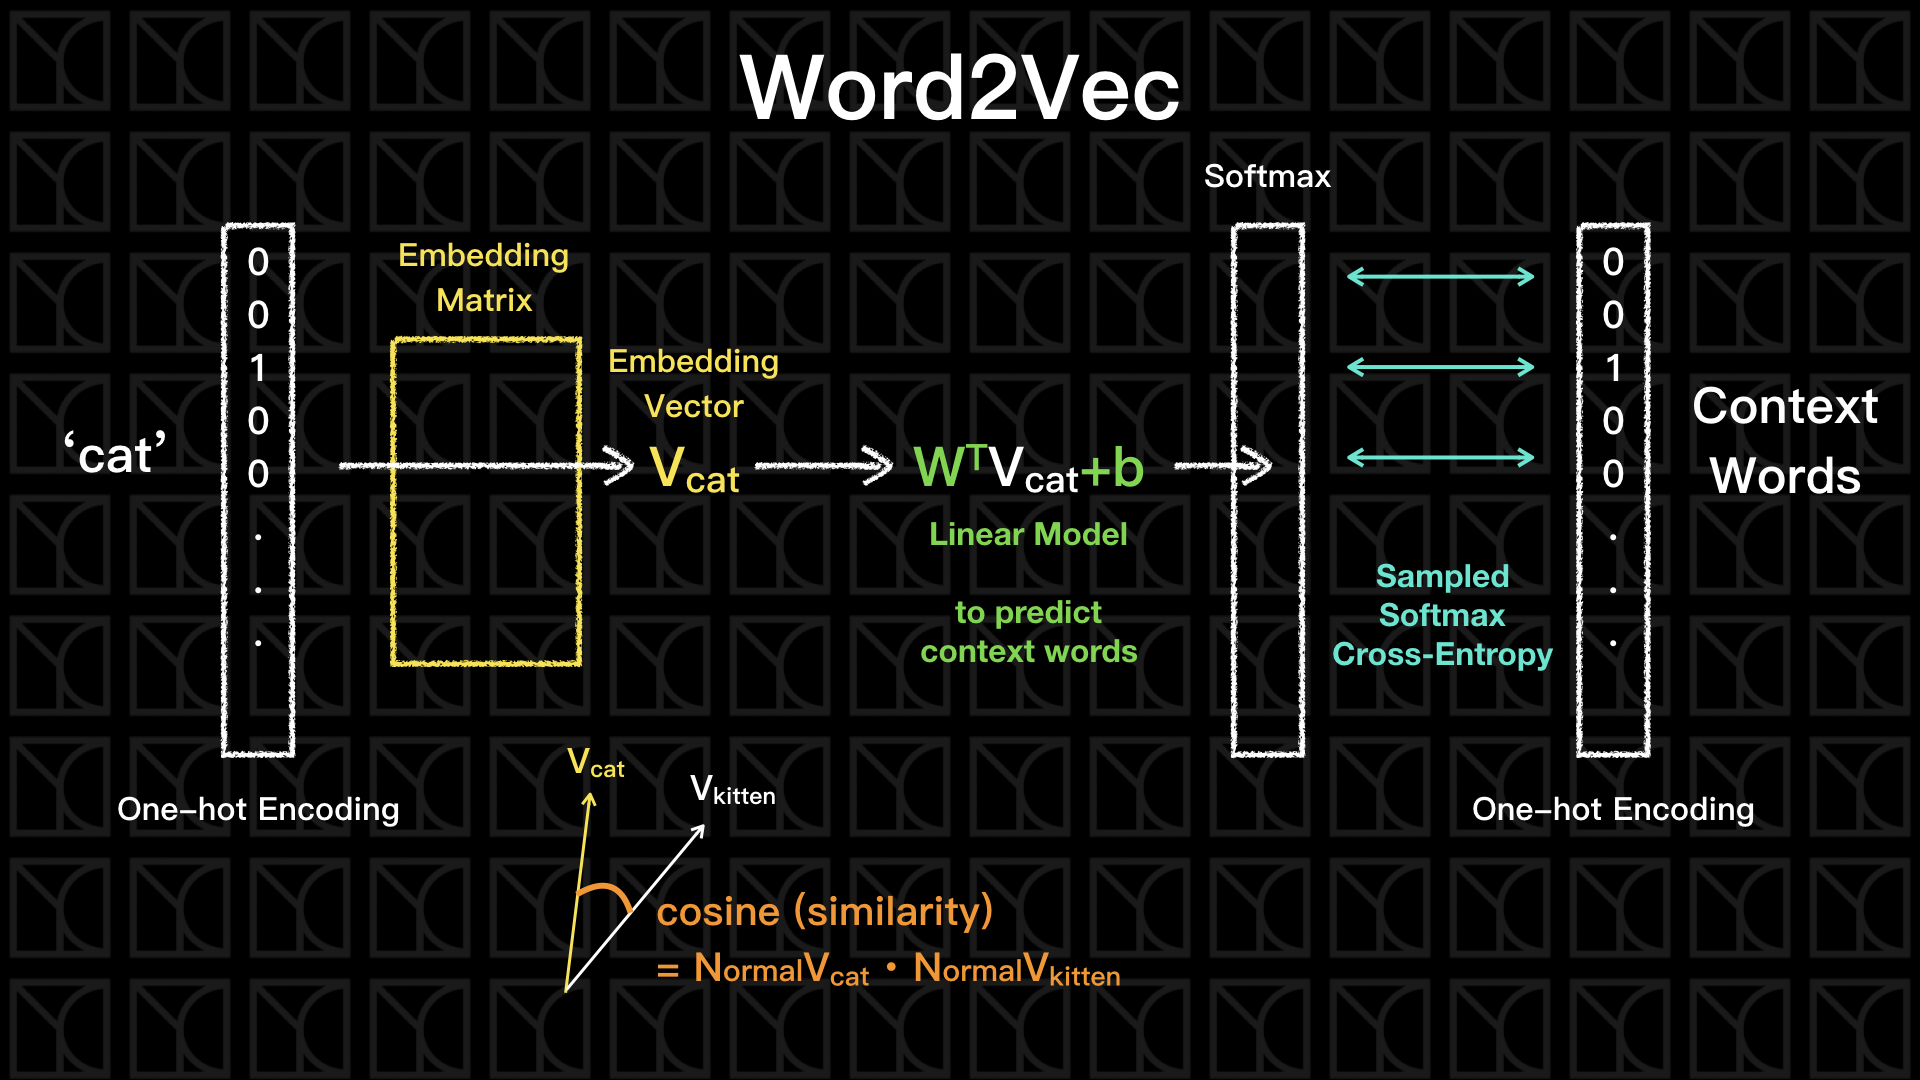

In [20]:
sentences[0]

['<bos>',
 'guy',
 'walking',
 'around',
 'without',
 'motive',
 'never',
 'get',
 'two',
 'hour',
 'life',
 'back']

In [21]:
embed_dim = 300
w2v_model = Word2Vec(sentences=sentences, vector_size=embed_dim, window=5, min_count=1, workers=4)

In [22]:
w2v_model.train(sentences, epochs=10, total_examples=len(sentences))

(29220112, 33131340)

In [23]:
unique_words = sorted(list({word for sentence in sentences for word in sentence}))


In [24]:
count_words = len(unique_words)

In [25]:
# encoded_corp = [one_hot(' '.join(sentence), count_words) for sentence in sentences]
one_hot_dict = {
    word : i  for i, word in enumerate(unique_words, 1)
}

encoded_corp = [
                    
                        ([
                            one_hot_dict[word] for word in nltk.flatten(text)
                        ], score) 
                    for score, texts in processed_corpus.items() for text in texts
                ]

max_lenth_sen = max(len(text[0]) for text in encoded_corp)
print(max_lenth_sen)

1428


In [26]:
word_vec_dict = {
    word : w2v_model.wv.get_vector(word) for word in unique_words
}

In [27]:
embed_matrix = np.zeros(shape = (count_words+1, embed_dim))
for i, word in enumerate(unique_words, 1):
    embed_vector = word_vec_dict.get(word)
    if embed_vector is not None:  
        embed_matrix[i] = embed_vector
    
# embed_matrix[0] = embed_matrix[0] * 0

In [28]:
pad_corp = pad_sequences([text for text, score in encoded_corp], 
                          maxlen = max_lenth_sen, 
#                          padding = 'post', 
                          value = 0.0)
y = [score for text, score in encoded_corp]
print(pad_corp[0].shape)

(1428,)


In [29]:
def one_hot_word(item, lenth):
    vector = np.zeros([1, lenth])
    vector[0][item] = 1
    return vector

In [39]:
def encode_corpus(corpus, encoded_one_hot_dict):
    new_corpus = [[encoded_one_hot_dict[word] for word in text] for text in corpus]
    return new_corpus

In [35]:
encoded_one_hot_dict = {
    i : one_hot_word(i , count_words+1) for i in range(count_words+1)
}

In [37]:
encoded_one_hot_dict[count_words]

array([[0., 0., 0., ..., 0., 0., 1.]])

In [41]:
X = encode_corpus(pad_corp, encoded_one_hot_dict)


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [47]:
model = keras.Sequential()
model.add(Embedding(input_dim = count_words + 1,
                    output_dim = embed_dim,
                    input_length = max_lenth_sen,
                    embeddings_initializer = Constant(embed_matrix)))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(embed_dim)))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.50))

model.add(Dense(len(corpus.keys()), activation = keras.activations.softmax))

2023-07-25 13:04:31.372254: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 119448000 exceeds 10% of free system memory.


In [48]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1428, 300)         29862000  
                                                                 
 bidirectional (Bidirection  (None, 600)               1442400   
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                38464     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 31343514 (119.57 MB)
Trainable params: 31343514 (119.57 MB)
Non-trainable params: 0 (0.00 Byte)
__________

In [49]:
model.compile(optimizer = keras.optimizers.RMSprop(learning_rate=1e-3),
              loss = 'crossentropy',
              metrics=['accuracy'])

In [50]:
epochs=5
batch_size=64

In [51]:
model.fit(X_train,y_train,
          epochs = epochs,
          batch_size = batch_size,
          validation_data = (X_test,y_test))

ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {'(<class \'list\'> containing values of types {"<class \'numpy.ndarray\'>"})'}), (<class 'list'> containing values of types {"<class 'int'>"})

In [ ]:
model.predict(X_train[0])

In [52]:
X_train[0]

[array([[1., 0., 0., ..., 0., 0., 0.]]),
 array([[1., 0., 0., ..., 0., 0., 0.]]),
 array([[1., 0., 0., ..., 0., 0., 0.]]),
 array([[1., 0., 0., ..., 0., 0., 0.]]),
 array([[1., 0., 0., ..., 0., 0., 0.]]),
 array([[1., 0., 0., ..., 0., 0., 0.]]),
 array([[1., 0., 0., ..., 0., 0., 0.]]),
 array([[1., 0., 0., ..., 0., 0., 0.]]),
 array([[1., 0., 0., ..., 0., 0., 0.]]),
 array([[1., 0., 0., ..., 0., 0., 0.]]),
 array([[1., 0., 0., ..., 0., 0., 0.]]),
 array([[1., 0., 0., ..., 0., 0., 0.]]),
 array([[1., 0., 0., ..., 0., 0., 0.]]),
 array([[1., 0., 0., ..., 0., 0., 0.]]),
 array([[1., 0., 0., ..., 0., 0., 0.]]),
 array([[1., 0., 0., ..., 0., 0., 0.]]),
 array([[1., 0., 0., ..., 0., 0., 0.]]),
 array([[1., 0., 0., ..., 0., 0., 0.]]),
 array([[1., 0., 0., ..., 0., 0., 0.]]),
 array([[1., 0., 0., ..., 0., 0., 0.]]),
 array([[1., 0., 0., ..., 0., 0., 0.]]),
 array([[1., 0., 0., ..., 0., 0., 0.]]),
 array([[1., 0., 0., ..., 0., 0., 0.]]),
 array([[1., 0., 0., ..., 0., 0., 0.]]),
 array([[1., 0.,